# Installing dependencies

In [1]:
!pip install node2vec
!pip install pycountry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
mlxte

In [2]:
speech = "Free market is an economic system based purely on supply and demand. This quintessential system however is used as a disguise to hide corruption and crony capilaism. It is used to hide a system where companies benefit not from free enterprise but from their relation with the government. Under this disguise of economic liberalization, governments privatize their companies unfairly with low prices, exclusive contracts, and regulatory capture. Corruption in privatization processes undermines economic stability, erodes public trust, and distorts the principles of free market economies. During privatization, government officials may be compelled to give unfair advantages to companies beneficial for themselves. By promoting stock holding disclosure and facilitating random audits, we can improve transparency within nations undergoing significant change. Promoting transparency in crucial in ensuring that privatization happens fairly. Transparency in privatization isn’t just a moral imperative; it is essential in attracting foreign investment and ensuring sustainable economic growth. A vote for this directive is a vote to uphold the values of free market during this critical period of economic transformation"

# Policy Embeddings
In this notebook, I vectorized each nation's political stance by:
- cleaning text
- embedding country speeches with semantic segmentation and averaging
- graph based knowledge embedding utilzied country information such as: political bloc, voting record
- combining vectors

# Cleaning Text

In [3]:
# Function for cleaning data
import re
def clean_text(text: str) -> str:
    """Clean text by removing country names while preserving stopwords"""

    country_names = [
        "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", 
        "Antigua", "Argentina", "Armenia", "Australia", "Austria",
        "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados",
        "Belarus", "Belgium", "Belize", "Benin", "Bhutan",
        "Bolivia", "Bosnia", "Botswana", "Brazil", "Brunei",
        "Bulgaria", "Burkina", "Burundi", "Cambodia", "Cameroon",
        "Canada", "Cape Verde", "Central African Republic", "Chad", "Chile",
        "China", "Colombia", "Comoros", "Congo", "Costa Rica",
        "Croatia", "Cuba", "Cyprus", "Czech Republic", "Denmark",
        "Djibouti", "Dominica", "Dominican Republic", "Ecuador", "Egypt",
        "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini",
        "Ethiopia", "Fiji", "Finland", "France", "Gabon",
        "Gambia", "Georgia", "Germany", "Ghana", "Greece",
        "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana",
        "Haiti", "Honduras", "Hungary", "Iceland", "India",
        "Indonesia", "Iran", "Iraq", "Ireland", "Israel",
        "Italy", "Ivory Coast", "Jamaica", "Japan", "Jordan",
        "Kazakhstan", "Kenya", "Kiribati", "Korea", "Kosovo",
        "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon",
        "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania",
        "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives",
        "Mali", "Malta", "Marshall Islands", "Mauritania", "Mauritius",
        "Mexico", "Micronesia", "Moldova", "Monaco", "Mongolia",
        "Montenegro", "Morocco", "Mozambique", "Myanmar", "Namibia",
        "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua",
        "Niger", "Nigeria", "North Korea", "North Macedonia", "Norway",
        "Oman", "Pakistan", "Palau", "Panama", "Papua New Guinea",
        "Paraguay", "Peru", "Philippines", "Poland", "Portugal",
        "Qatar", "Romania", "Russia", "Rwanda", "Saint Kitts",
        "Saint Lucia", "Saint Vincent", "Samoa", "San Marino", "Sao Tome",
        "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone",
        "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "Somalia",
        "South Africa", "South Korea", "South Sudan", "Spain", "Sri Lanka",
        "Sudan", "Suriname", "Sweden", "Switzerland", "Syria",
        "Taiwan", "Tajikistan", "Tanzania", "Thailand", "Timor-Leste",
        "Togo", "Tonga", "Trinidad", "Tunisia", "Turkey",
        "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates",
        "United Kingdom", "United States", "Uruguay", "Uzbekistan", "Vanuatu",
        "Vatican City", "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe"
    ]
    
    country_names += [
        "USA", "UK", "UAE", "PRC", "DPRK", 
        "ROK", "DRC", "U.S.", "U.K.", "America",
        "Britain", "England", "Scotland", "Wales", "Northern Ireland",
        "Hong Kong", "Macau", "Palestine", "Ivory Coast", "Czechia",
        "Macedonia", "Swaziland", "Burma", "East Timor", "Vatican"
    ]
    text = re.sub(r'\b(?:the\s+)?(?:delegation\s+of\s+)?(?:representative\s+of\s+)?(' + 
                  '|'.join(country_names) + r')\b', '[COUNTRY]', text, flags=re.IGNORECASE)
    
    text = re.sub(r'[^\w\s\[\]]', ' ', text) 
    text = text.lower()

    text = ' '.join(text.split()).strip()
    
    return text[:3000]

# Semantic Segmentation using GPT 4o

In [4]:
import json
def get_segments(text: str, max_tokens = 200) -> list[str]:
    paragraphs = [p for p in text.split('\n') if p.split()]

    num_seg = max(0, len(text.split())//max_tokens) + 3
    print(f"Num segments: {num_seg}")
    system =     system = f"""
    You will do semantic segmentation of the following text and output the result as a JSON string.
    Segment this diplomatic text into {num_seg} coherent policy segments.
    Each segment should focus on a single policy theme (e.g., economic policy, 
    security concerns, human rights, international cooperation).
    Preserve diplomatic context and policy coherence within each segment.
    
    Return the result as JSON with this exact format:
    {{"segments": ["segment1", "segment2", "segment3"]}}
    """
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": speech}
        ],
        response_format={"type": "json_object"}
    )
    
    segments = json.loads(response.choices[0].message.content)["segments"]
    if not len(paragraphs) == 1:
        segments.append(paragraphs)
    segments.append(text)
    print(f"Generated {len(segments)} segments. ")
    return segments

In [5]:
import pandas as pd
from kaggle_secrets import UserSecretsClient
from openai import AzureOpenAI
import os
from openai import OpenAI

user_secrets = UserSecretsClient()

api = user_secrets.get_secret("OPENAI_API_KEY")
client = AzureOpenAI(
    api_key=api,
    api_version="2024-11-01-preview",
    azure_endpoint="https://swedencentral.api.cognitive.microsoft.com"
)

# Ensemble Embeddings using text-embedding-3-large & bge-large-en-v1.5

In [6]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
import numpy as np

def generate_embeddings(texts: list[str]):
    stm = SentenceTransformer('BAAI/bge-large-en-v1.5')
    embeddings = []
    for i in texts:
        bge = stm.encode(i)
        response = client.embeddings.create(
            model="text-embedding-3-large",
            input=i
        )
        emb1 = normalize([response.data[0].embedding])[0]
        emb2 = normalize([bge])[0]
        embedding = np.concatenate([emb1, emb2])
        embeddings.append(embedding)
    
    fin_emb = []
    
    for i in range(len(embeddings)):
        fin_emb.append(list(embeddings[i]))
    return fin_emb

texts = get_segments(speech)
embeddings = generate_embeddings(texts)
print(len(embeddings))

2025-06-01 00:49:38.290414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748738978.537932      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748738978.611441      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num segments: 3
Generated 4 segments. 


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

4


# Knowledge injecting using node graphs

# Generating embeddings for every country speech

In [7]:
import pycountry
data = pd.read_csv("/kaggle/input/un-general-debates/un-general-debates.csv")
data = data.drop(columns=['session', 'year'])

code_to_country = {country.alpha_3: country.name for country in pycountry.countries}

data['country'] = data['country'].map(code_to_country)
data.head()

,country,text
0,Maldives,﻿It is indeed a pleasure for me and the member...
1,Finland,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,Niger,"﻿\nMr. President, it is a particular pleasure ..."
3,Uruguay,﻿\nDuring the debate at the fortieth session o...
4,Zimbabwe,﻿I should like at the outset to express my del...


## Generated Embeddings:

In [8]:
df = pd.read_csv("/kaggle/input/better-speech-embeddings/country_embeddings_optimized.csv").transpose()
df2 = pd.read_csv("/kaggle/input/2-hour-speech-embedding-average-5200-speeches/my_file.csv")
df.columns = df2.columns
df.drop('Unnamed: 0', inplace=True)
df.index = range(0, 4096)

In [9]:
import networkx as nx
from itertools import combinations
from node2vec import Node2Vec

import pandas as pd

IGO = pd.read_csv("/kaggle/input/political-igos/Major Political IGOs Expanded.csv")
IGO["Member Countries"] = IGO["Member Countries"].apply(lambda x: str(x.split("; ")))

organizations = {IGO.iloc[i]['IGO Name'] : IGO.iloc[i]['Member Countries'] for i in range(len(IGO))}

In [10]:
import ast

# Convert stringified lists into actual lists
for k in organizations:
    if isinstance(organizations[k], str):
        organizations[k] = ast.literal_eval(organizations[k])

In [11]:
edges = []
for members in organizations.values():
    edges.extend(combinations(members, 2))

G = nx.Graph()
G.add_edges_from(edges)

node2vec = Node2Vec(G, dimensions=4096, walk_length=30, num_walks=200, workers=2)

model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/200 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


In [12]:
import pandas as pd
import networkx as nx
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
import random

def plot_country_IGO(num: int):
    country_igos = {}
    for _, row in IGO.iterrows():
        for country in row["Member Countries"]:
            if country not in country_igos:
                country_igos[country] = []
            country_igos[country].append(row["IGO Name"])
    
    shared_igos = {}
    countries = list(country_igos.keys())
    for c1, c2 in combinations(countries, 2):
        common_igos = set(country_igos[c1]) & set(country_igos[c2])
        shared_igos[(c1, c2)] = len(common_igos)
        shared_igos[(c2, c1)] = len(common_igos)
    
    G_weighted = nx.Graph()
    for (c1, c2), weight in shared_igos.items():
        if weight > 0:
            G_weighted.add_edge(c1, c2, weight=weight)
    
    selected_countries = random.sample(countries, num)
    
    adj_matrix = nx.to_numpy_array(G_weighted, nodelist=selected_countries, weight="weight")
    adj_df = pd.DataFrame(adj_matrix, index=selected_countries, columns=selected_countries)
    plt.figure(figsize=(15, 12))
    sns.heatmap(
        adj_df,
        cmap="YlOrRd",
        square=True,
        linewidths=0.3,
        annot=True,
        cbar_kws={"label": "Number of Shared IGOs"},
    )
    
    plt.title("Number of Shared IGO Memberships (30 Random Countries)", fontsize=16)
    plt.xlabel("Country", fontsize=12)
    plt.ylabel("Country", fontsize=12)
    plt.xticks(rotation=90, fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.show()

def get_organizations(country: str):
    return [igo for igo, members in organizations.items() if country in members]

In [13]:
# import numpy as np
# import pandas as pd
# import openai
# from collections import defaultdict

# grouped = (
#     data.groupby("country")
#     .apply(lambda x: x["text"].tail(5).tolist())
# )

# country_to_embedding = {}

# for country, speeches in grouped.items():
#     all_embeddings = [get_av_embedding(speech) for speech in speeches]
#     avg_embedding = np.mean(all_embeddings, axis=0)
#     country_to_embedding[country] = avg_embedding.tolist()  # Save as list for serialization

In [14]:
# df = pd.DataFrame(country_to_embedding)
# df.to_csv("/kaggle/working/my_file.csv", index=False)

In [15]:
df = df.drop(columns=['Holy See (Vatican City State)', 'Congo', 'Czechia', 'Congo, The Democratic Republic of the'])
df = df.rename(columns={'Viet Nam': 'Vietnam', 'Brunei Darussalam': 'Brunei','Iran, Islamic Republic of': 'Iran',"Lao People's Democratic Republic": 'Laos','Türkiye': 'Turkey','Syrian Arab Republic': 'Syria','Russian Federation': 'Russia', 'Palestine, State of': 'Palestine', 'Korea, Republic of': 'South Korea', "Korea, Democratic People's Republic of": 'North Korea', 'Bolivia, Plurinational State of': 'Bolivia', 'Moldova, Republic of': 'Moldova', 'Tanzania, United Republic of': 'Tanzania', 'Micronesia, Federated States of':'Micronesia', 'Venezuela, Bolivarian Republic of': 'Venezuela'})
for i in df.columns:
    if not i in list(model.wv.key_to_index.keys()):
        print(i)

In [16]:
#df = df.drop(columns=['Bolivia, Plurinational State of', 'Brunei Darussalam'])
countries = list(df.columns)
graph_data = []
speech_data = []
for country in countries:
    graph_data.append(list(model.wv[country]))
    speech_data.append(list(df[country]))

In [17]:
graph_data = np.array(graph_data)
speech_data = np.array(speech_data)
print(graph_data.shape, speech_data.shape)

(190, 4096) (190, 4096)


# Combining speech embeddings and knowledge based embeddings

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

class ProjectionMLP(nn.Module):
    def __init__(self, input_dim, output_dim=512):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim)
        )
    def forward(self, x):
        return self.projection(x)

# Replace with your real embeddings
speech_embeddings = graph_data
graph_embeddings = speech_data      # shape (N, d_graph)

# Convert to torch tensors
speech_tensor = torch.tensor(speech_embeddings, dtype=torch.float32)
graph_tensor = torch.tensor(graph_embeddings, dtype=torch.float32)

dataset = TensorDataset(speech_tensor, graph_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

d_speech = speech_tensor.shape[1]
d_graph = graph_tensor.shape[1]

speech_proj = ProjectionMLP(d_speech)
graph_proj = ProjectionMLP(d_graph)

optimizer = torch.optim.Adam(list(speech_proj.parameters()) + list(graph_proj.parameters()), lr=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

def contrastive_loss(proj1, proj2, temperature=0.07):
    batch_size = proj1.size(0)
    proj1 = F.normalize(proj1, dim=1)
    proj2 = F.normalize(proj2, dim=1)

    representations = torch.cat([proj1, proj2], dim=0)  # (2B, D)
    similarity_matrix = torch.matmul(representations, representations.T)  # (2B, 2B)

    # Remove self-similarity
    mask = torch.eye(2 * batch_size, device=proj1.device).bool()
    similarity_matrix = similarity_matrix.masked_fill(mask, -9e15)  # effectively -inf

    # Compute logits
    logits = similarity_matrix / temperature

    # Create labels: positive pairs are (i, i + B) and (i + B, i)
    labels = torch.cat([
        torch.arange(batch_size, device=proj1.device) + batch_size,
        torch.arange(batch_size, device=proj1.device)
    ])

    loss = F.cross_entropy(logits, labels)
    return loss

In [19]:
num_epochs = 200
history = []
for epoch in range(num_epochs):
    total_loss = 0
    for speech_batch, graph_batch in dataloader:
        optimizer.zero_grad()

        z_speech = speech_proj(speech_batch)
        z_graph = graph_proj(graph_batch)

        loss = contrastive_loss(z_speech, z_graph)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(speech_proj.parameters()) + list(graph_proj.parameters()), max_norm=1.0
        )
        optimizer.step()

        total_loss += loss.item()
    total_loss = total_loss / len(dataloader)
    history.append(total_loss)
    scheduler.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

Epoch 1: Loss = 11.8330
Epoch 11: Loss = 2.4700
Epoch 21: Loss = 1.4820
Epoch 31: Loss = 0.6105
Epoch 41: Loss = 0.3100
Epoch 51: Loss = 0.3067
Epoch 61: Loss = 0.2739
Epoch 71: Loss = 0.2031
Epoch 81: Loss = 0.1391
Epoch 91: Loss = 0.0977
Epoch 101: Loss = 0.0402
Epoch 111: Loss = 0.0226
Epoch 121: Loss = 0.0174
Epoch 131: Loss = 0.0162
Epoch 141: Loss = 0.0118
Epoch 151: Loss = 0.0124
Epoch 161: Loss = 0.0125
Epoch 171: Loss = 0.0114
Epoch 181: Loss = 0.0111
Epoch 191: Loss = 0.0101


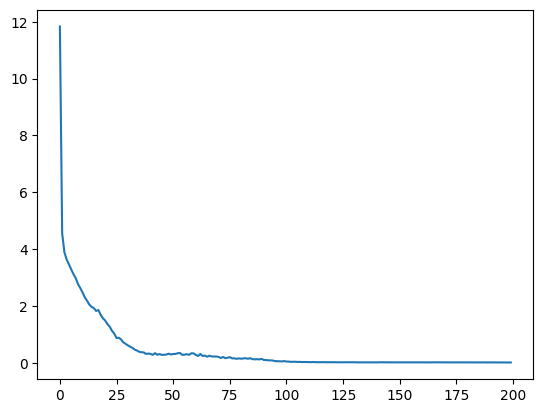

In [20]:
import matplotlib.pyplot as plt

plt.plot(history)

In [21]:
with torch.no_grad():
    speech_aligned = F.normalize(speech_proj(speech_tensor), dim=1)
    graph_aligned = F.normalize(graph_proj(graph_tensor), dim=1)

    # Optional: concatenate
    combined_embedding = 0.5 * speech_aligned + 0.5 * graph_aligned
    combined_embedding = torch.reshape(combined_embedding, (512, 190))

In [22]:
np_array = combined_embedding.detach().cpu().numpy()

final_country_embeddings = pd.DataFrame(np_array, columns=countries)

final_country_embeddings

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,0.002664,-0.010688,-0.015893,0.000259,0.013338,0.016621,-0.023335,0.003527,0.029001,-0.019174,...,-0.058668,0.013118,0.131581,0.004390,-0.009732,-0.003931,-0.005497,-0.001205,-0.011365,-0.014843
1,0.001775,-0.013440,0.000221,-0.011448,0.007217,0.012470,0.023057,0.000012,0.010230,0.018543,...,-0.004804,-0.025305,0.005993,-0.002015,-0.010592,0.045238,0.001241,-0.021603,0.007153,-0.018969
2,-0.025670,0.007799,0.018792,-0.004711,0.003838,-0.030220,-0.006389,0.008527,-0.020567,-0.002506,...,0.004837,-0.003972,0.045371,-0.027457,0.050204,-0.006875,-0.012742,0.063418,0.014568,-0.009189
3,0.117441,-0.014387,-0.001997,0.031464,-0.065456,-0.009705,-0.003522,-0.007798,0.015909,0.041832,...,0.003778,-0.005269,-0.003756,0.013477,0.036678,-0.013544,0.189180,0.011639,-0.008183,-0.012050
4,-0.034047,-0.044534,0.071313,0.001040,0.003411,0.027857,-0.002183,-0.015481,-0.003072,0.002752,...,0.032744,-0.032623,-0.013381,-0.017065,0.032443,0.014014,-0.007315,0.026746,0.030078,0.038602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.022899,0.006925,-0.009888,-0.032213,-0.019380,-0.020107,0.032150,0.079937,0.022892,0.096490,...,-0.009919,0.029244,0.028749,0.018011,0.019214,0.047592,0.036183,0.027792,-0.018824,-0.036018
508,0.034620,-0.021509,0.010075,-0.021756,0.018251,-0.016229,-0.005095,0.024080,-0.041909,-0.056890,...,-0.009290,0.099837,0.034291,0.009270,-0.010327,-0.007055,-0.006616,0.038809,0.002966,0.062308
509,0.011924,-0.029549,0.003811,-0.069902,0.059533,0.060308,-0.025158,-0.000197,0.025264,-0.065039,...,0.005747,0.014001,0.034844,0.001231,-0.035518,0.026645,-0.002761,0.026273,-0.070418,-0.014423
510,-0.019453,0.047185,0.113610,-0.069055,0.209606,-0.000062,0.042340,0.012953,-0.020168,0.027578,...,-0.000767,-0.007351,0.007374,-0.158647,0.050808,0.068380,-0.007318,-0.030358,-0.005159,-0.025428


In [23]:
def get_av_embedding(speech: str):
    clean_speech = clean_text(speech)
    segments = get_segments(clean_speech)
    embeddings = generate_embeddings(segments)
    vec = np.array(embeddings)
    return np.mean(vec, axis=0)

In [24]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def generate_country_similarity(speech: str, place: str):

    or_encode = np.array(generate_embeddings([speech])[0])
    vec = np.array(embeddings)
    av_vec = np.mean(vec, axis=0)
    topic_consistency = cosine_similarity(av_vec.reshape(1, -1), or_encode.reshape(1, -1))[0][0]
    print(f"Topic consistency: {topic_consistency}")
    
    av_vec = torch.tensor(av_vec, dtype=next(speech_proj.parameters()).dtype)
    print(av_vec.dtype)
    av_vec = av_vec.unsqueeze(0)
    speech_proj.eval()  # disables batch norm stat updates and dropout
    with torch.no_grad():
        av_vec = F.normalize(speech_proj(av_vec), dim=1)
    
    lis = []
    for column in final_country_embeddings.columns:
        cs = cosine_similarity(
            av_vec.detach().numpy().reshape(1, -1),
            np.array(list(final_country_embeddings[column])).reshape(1, -1)
        )
        lis.append((cs[0][0], column))
    sorted_data = sorted(lis, key=lambda x: x[0], reverse=True)
    for score, country in sorted_data:
        if country == place:
            print(f'\n\n-----{place}------\n\n')
            print(f"{score:.8f} — {country}")
            print('\n\n')
        else:
            print(f"{score:.8f} — {country}")
def compare_countries(country1, country2):
    cosine_similarity(
        np.array(list(final_country_embeddings[country1])).reshape(1, -1),
        np.array(list(final_country_embeddings[country2])).reshape(1, -1)
    )

In [25]:
speech = "Since the Central African Republic’s independence in 1960, resilience has drastically shaped our nation. We stand before this assembly to address problems such as sociocultural grievance driven protests, which have necessitated policies banning political demonstrations to limit civil unrest, violence and other heinous acts. While controversial, these measures have been crucial for political stability. We also acknowledge issues within our peacekeeping forces, including systemic flaws and abuses, and have sought international supervision from observer organizations to address these cases. Water deprivation in war torn regions remains an imperative concern, exacerbated by recent conflicts. Short-term solutions like sand dams and temporary wells have proven effective, and the Central African Republic is fervent in providing insight on said issues. Finally, regarding Haiti's gang violence, we sympathize with those struggling, as we’ve faced similar struggles with ethnic conflict driven by resources and territory. Collaborative efforts, inspired by initiatives like MINUSCA, can prove to be crucial at elucidating the core of this problem. We urge member states to unite in addressing these challenges, fostering peace, and securing vital resources. Thank you."
generate_country_similarity(speech, 'Central African Republic')

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Topic consistency: 0.40284285440288703
torch.float32
0.11045199 — Antigua and Barbuda
0.09735453 — Nigeria
0.09622544 — Bulgaria
0.09535088 — Senegal
0.08950924 — Morocco
0.08541879 — Belgium
0.08400391 — Chile
0.07637500 — Netherlands
0.07604795 — Suriname
0.07425648 — Equatorial Guinea
0.07278445 — Guatemala
0.07219260 — El Salvador
0.07090407 — Costa Rica
0.06360023 — Cyprus
0.06220658 — Palestine
0.06165590 — Thailand
0.06021397 — Kiribati
0.05957386 — Saudi Arabia
0.05785860 — Australia
0.05710041 — Sudan
0.05283510 — Israel
0.05240479 — Madagascar
0.05193352 — Albania
0.05059758 — Iceland
0.04766279 — Angola
0.04672151 — Côte d'Ivoire
0.04605172 — Uruguay
0.04526410 — Sri Lanka
0.04464604 — Cabo Verde
0.04452914 — Malta
0.04416988 — Benin
0.04354957 — Mali
0.04199923 — Burundi
0.04159848 — Denmark
0.04056472 — Greece
0.03979385 — Fiji
0.03893669 — Kenya
0.03824099 — Portugal
0.03781999 — Mauritius
0.03750580 — Honduras
0.03690512 — Kyrgyzstan
0.03677082 — Eswatini
0.03564129 — Na